## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2019.

# Task 1: XOR

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
from numpy.random import shuffle
import time
import matplotlib.pyplot as plt

# Plot configurations 1115
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 1, Part 1: Backpropagation through time (BPTT)

**Question:** Consider a simple RNN network shown in the following figure, where _wx, wh, b1, w, b2_ are the scalar parameters of the network. The loss function is the **mean squared error (MSE)**. Given input _(x1, x2) = (-1, 0)_, ground truth _(g1, g2) = (1, 0), h0 = 0, (wx, wh, b1, w, b2) = (2, 1, 1, 2, 1)_, compute _(dwx, dwh, db1, dw, db2)_, which are the gradients of loss with repect to 5 parameters _(wx, wh, b1, w, b2)_.

![bptt](./img/bptt2.jpg)

<span style="color:red">TODO:</span>

Answer the above question. 

* **[fill in here: Enter your derivations and the computational process
MSE=]**
* You can use LATEX to edit the equations, and Jupyter notebook can recognize basic LATEX syntax. Alternatively, you can edit equations in some other environment and then paste the screenshot of the equations here.
![img](img/task1_computation2.png)

In [3]:
# use tensorflow to verify the answer.
w = tf.Variable(2.0)
b2 = tf.Variable(1.0)
wx = tf.Variable(2.0)
wh = tf.Variable(1.0)
b1 = tf.Variable(1.0)

h0 = tf.Variable(0.0)
x = tf.placeholder(tf.float32, shape=(2,))
g = tf.placeholder(tf.float32, shape=(2,))

y = []
h1 = tf.sigmoid(wx*x[0] + wh*h0 + b1)
y.append(tf.sigmoid(w*h1 + b2))
h2 = tf.sigmoid(wx*x[1] + wh*h1 + b1)
y.append(tf.sigmoid(w*h2 + b2))

loss = 0.5*(tf.square(g[0]-y[0]) + tf.square(g[1]-y[1]))

dw, db2, dwx, dwh, db1 = tf.gradients(loss, [w, b2, wx, wh, b1])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    dw_t, db2_t, dwx_t, dwh_t, db1_t = sess.run([dw, db2, dwx, dwh, db1],
                                              feed_dict={x: np.asarray([-1.0,0.0]), g: np.asarray([1.0,0.0])})
print("verify by tensorflow")
print("dw = {:.4f}, db2 = {:.4f}, dwx = {:.4f}, dwh = {:.4f}, db1 = {:.4f}".format(dw_t, db2_t, dwx_t, dwh_t, db1_t))

Instructions for updating:
Colocations handled automatically by placer.
verify by tensorflow
dw = 0.0413, db2 = 0.0360, dwx = 0.0060, dwh = 0.0057, db1 = 0.0152


## Task 1, Part 2: Use tensorflow modules to create XOR network

In this part, you need to build and train an XOR network that can learn the XOR function. It is a very simple implementation of RNN and will give you an idea how RNN is built and how to train it.

### XOR network

XOR network can learn the XOR $\oplus$ function

As shown in the figure below, and for instance, if input $(x0, x1, x2)$=(1,0,0), then output $(y1, y2, y3)$=(1,1,1). That is, $y_n = x_0\oplus x_1 \oplus ... \oplus x_{n-1}$

![xor_net](./img/xor.png)

### Create data set
This function provides you the way to generate the data which is required for the training process. You should utilize it when building your training function for the GRU. Please read the source code for more information.

In [4]:
from utils.xor.dataset import create_dataset

### (Demo) Build a network using a Tensorlow LSTMCell and GRUCell
This section shows an example how to build a RNN network using an LSTM cell or GRU cell. Both LSTM and GRU cell are inbuilt classes in tensorflow which separately implement the real behavior of the LSTM and GRU neuron. 

Reference: 
1. [TensorFlow LSTM cell](https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/LSTMCell)
1. [TensorFlow GRU cell](https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/GRUCell)
2. [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)

#### LSTM

In [7]:
from tensorflow.contrib.rnn import LSTMCell

# define LSTM cell
lstm_units = 64
cell = LSTMCell(lstm_units,num_proj=2,state_is_tuple=True)


tf.reset_default_graph()

# Input shape: (num_samples, seq_length, input_dimension)
# Output shape: (num_samples, output_ground_truth), and output_ground_truth is 0/1.
input_data = tf.placeholder(tf.float32, shape=[None,None,1])
output_data = tf.placeholder(tf.int64, shape=[None,None])

# create LSTM network: you can also choose other modules provided by tensorflow, like static_rnn etc.
hidden, _ = tf.nn.dynamic_rnn(cell, input_data, dtype=tf.float32)

# generate output from the hidden information
output_shape = 2
out = tf.layers.dense(hidden, output_shape)
pred = tf.argmax(out, axis=2)

# loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=output_data,logits=out))

# optimization
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

# accuracy
correct_num = tf.equal(output_data,pred)
accuracy = tf.reduce_mean(tf.cast(correct_num,tf.float32))

#### GRU

In [8]:
from tensorflow.contrib.rnn import GRUCell

# define GRU cell
gru_units = 64
cell = GRUCell(gru_units)


tf.reset_default_graph()

# Input shape: (num_samples, seq_length, input_dimension)
# Output shape: (num_samples, output_ground_truth), and output_ground_truth is 0/1.
input_data = tf.placeholder(tf.float32, shape=[None,None,1])
output_data = tf.placeholder(tf.int64, shape=[None,None])

# create GRU network: you can also choose other modules provided by tensorflow, like static_rnn etc.
hidden, _ = tf.nn.dynamic_rnn(cell, input_data, dtype=tf.float32)

# generate output from the hidden information
output_shape = 2
out = tf.layers.dense(hidden, output_shape)
pred = tf.argmax(out, axis=2)

# loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=output_data,logits=out))

# optimization
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

# accuracy
correct_num = tf.equal(output_data,pred)
accuracy = tf.reduce_mean(tf.cast(correct_num,tf.float32))

### Training 

<span style='color:red'>TODO:</span> 
1. Build your training function for RNN (choose either LSTM or GRU); 
2. Plot the cost during the training

In [26]:
# TODO: training
# First, generate dataset
X_train, y_train=create_dataset(5000,8)
# Init
epoch=30
train_loss=[]
# refer to the function in the previous homework.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        print("epoch: {}".format(i+1))
        _,current_loss=sess.run([optimizer,loss],feed_dict={input_data:X_train,output_data:y_train})
        print("loss= {}".format(current_loss))
        train_loss.append(current_loss)

epoch: 1
loss= 0.6926440000534058
epoch: 2
loss= 0.7098047137260437
epoch: 3
loss= 0.7499566674232483
epoch: 4
loss= 0.6878140568733215
epoch: 5
loss= 0.7009798884391785
epoch: 6
loss= 0.7002521753311157
epoch: 7
loss= 0.6916649341583252
epoch: 8
loss= 0.6856435537338257
epoch: 9
loss= 0.6845898032188416
epoch: 10
loss= 0.6783310770988464
epoch: 11
loss= 0.6682986617088318
epoch: 12
loss= 0.6595194935798645
epoch: 13
loss= 0.6306812763214111
epoch: 14
loss= 0.5953673720359802
epoch: 15
loss= 0.5375534892082214
epoch: 16
loss= 0.5002279877662659
epoch: 17
loss= 0.3022981584072113
epoch: 18
loss= 0.3710448443889618
epoch: 19
loss= 0.15813125669956207
epoch: 20
loss= 0.09121103584766388
epoch: 21
loss= 0.185941681265831
epoch: 22
loss= 0.039155229926109314
epoch: 23
loss= 0.3324223756790161
epoch: 24
loss= 0.016634689643979073
epoch: 25
loss= 0.01620708778500557
epoch: 26
loss= 0.0469779297709465
epoch: 27
loss= 0.06622765213251114
epoch: 28
loss= 0.03403016924858093
epoch: 29
loss= 0.023

<function matplotlib.pyplot.show(*args, **kw)>

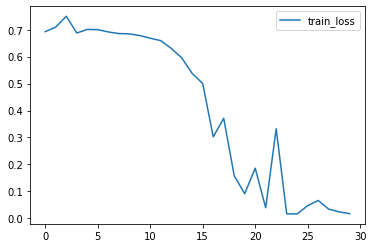

In [27]:
# TODO: plot loss history
plt.plot(train_loss,label="train_loss")
plt.legend()
plt.show

## Task 1, Part 3 :  Build your own LSTMCell
In this part, you need to build your own LSTM cell to achieve the LSTM functionality. 

<span style="color:red">TODO:</span> 
1. Finish class **MyLSTMCell** in utils/xor/rnn.py;
2. Write the training function for your RNN;
3. Plot the cost during training.

In [7]:
# from utils.xor.rnn import MyLSTMCell

In [16]:
# recreate xor netowrk with your own LSTM cell
from utils.xor.rnn import MyLSTMCell
tf.reset_default_graph()

#Input shape: (num_samples,seq_length,input_dimension)
#Output shape: (num_samples, output_ground_truth), and output_ground_truth is 0/1. 
input_data = tf.placeholder(tf.float32,shape=[None,None,1])
output_data = tf.placeholder(tf.int64,shape=[None,None])

# recreate xor netowrk with your own LSTM cell
lstm_units = 64
cell = MyLSTMCell(lstm_units,num_proj=2)

# create GRU network: you can also choose other modules provided by tensorflow, like static_rnn etc.
hidden, _ = tf.nn.dynamic_rnn(cell,input_data,dtype=tf.float32)

# generate output from the hidden information
output_shape = 2
out = tf.layers.dense(hidden, output_shape)
pred = tf.argmax(out,axis=2)

# loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=output_data,logits=out))
# optimization
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
# accuracy
correct = tf.equal(output_data,pred)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

### Training

In [17]:
# TODO: training
# First, generate dataset
X_train, y_train=create_dataset(5000,8)
# Init
epoch=30
train_loss=[]
# refer to the function in the previous homework
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        print("epoch: {}".format(i+1))
        _,current_loss=sess.run([optimizer,loss],feed_dict={input_data:X_train,output_data:y_train})
        print("loss= {}".format(current_loss))
        train_loss.append(current_loss)

epoch: 1
loss= 1.5643529891967773
epoch: 2
loss= 0.8119238615036011
epoch: 3
loss= 1.3741962909698486
epoch: 4
loss= 0.9713070392608643
epoch: 5
loss= 0.7305314540863037
epoch: 6
loss= 0.6956502199172974
epoch: 7
loss= 0.6932949423789978
epoch: 8
loss= 0.7065271735191345
epoch: 9
loss= 0.7205525636672974
epoch: 10
loss= 0.7293788194656372
epoch: 11
loss= 0.7317215800285339
epoch: 12
loss= 0.7285776138305664
epoch: 13
loss= 0.721890926361084
epoch: 14
loss= 0.7137463092803955
epoch: 15
loss= 0.7059046626091003
epoch: 16
loss= 0.6995717883110046
epoch: 17
loss= 0.6953554153442383
epoch: 18
loss= 0.6933141350746155
epoch: 19
loss= 0.6931008100509644
epoch: 20
loss= 0.6941125392913818
epoch: 21
loss= 0.6956744194030762
epoch: 22
loss= 0.6971731185913086
epoch: 23
loss= 0.6981640458106995
epoch: 24
loss= 0.698410153388977
epoch: 25
loss= 0.6978821158409119
epoch: 26
loss= 0.6967207193374634
epoch: 27
loss= 0.6951708793640137
epoch: 28
loss= 0.6935221552848816
epoch: 29
loss= 0.6920406222343

<function matplotlib.pyplot.show(*args, **kw)>

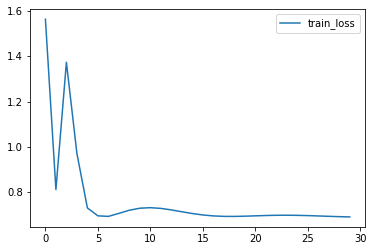

In [18]:
# TODO: plot loss history
plt.plot(train_loss,label="train_loss")
plt.legend()
plt.show